# 手写阿拉伯数字辨识 完整版

## 载入套件

In [65]:
import os
import torch
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torch import nn

## 检查GPU

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 载入 MNIST 手写阿拉伯数字资料

In [6]:
# 下载 MNIST 手写阿拉伯数字 训练资料
train_ds = MNIST("", train=True, download=True, 
                 transform=transforms.ToTensor())

# 下载测试资料
test_ds = MNIST("", train=False, download=True, 
                 transform=transforms.ToTensor())

# 训练/测试资料的维度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


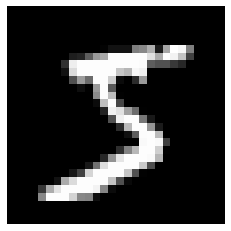

In [7]:
# 显示第1张图片图像
import matplotlib.pyplot as plt

# 第一笔资料
X = train_ds.data[0]

# 绘制点阵图，cmap='gray':灰阶
plt.imshow(X.reshape(28,28), cmap='gray')

# 隐藏刻度
plt.axis('off') 

# 显示图形
plt.show() 

## FashionMNIST

In [8]:
training_data = FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

## 任意抽样9笔资料显示

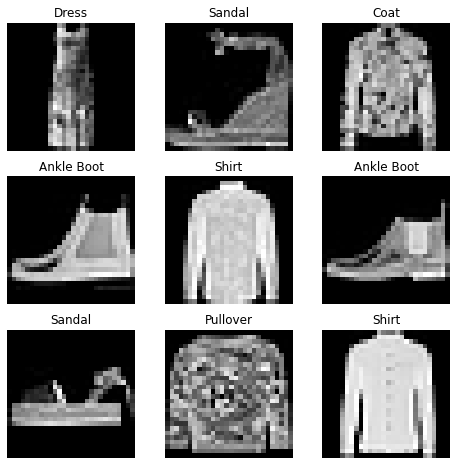

In [59]:
labels_map = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Transforms

In [10]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T

def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

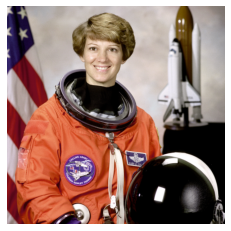

In [83]:
import skimage

orig_img = skimage.data.astronaut()
skimage.io.imsave('images_test/astronaut.jpg', orig_img)
plt.axis('off')
plt.imshow(orig_img)

In [86]:
# 转换输入须为 Pillow 格式
from PIL import Image

orig_img = Image.open('images_test/astronaut.jpg')

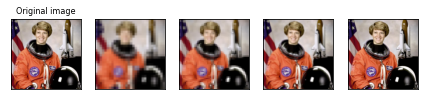

In [87]:
# resize
resized_imgs = [T.Resize(size=size)(orig_img) for size in (30, 50, 100, orig_img.size)]
plot(resized_imgs)

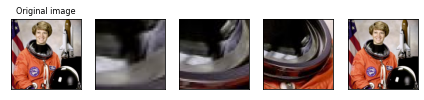

In [88]:
center_crops = [T.CenterCrop(size=size)(orig_img) for size in (30, 50, 100, orig_img.size)]
plot(center_crops)

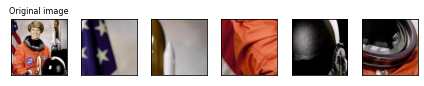

In [89]:
(top_left, top_right, bottom_left, bottom_right, center) = T.FiveCrop(size=(100, 100))(orig_img)
plot([top_left, top_right, bottom_left, bottom_right, center])

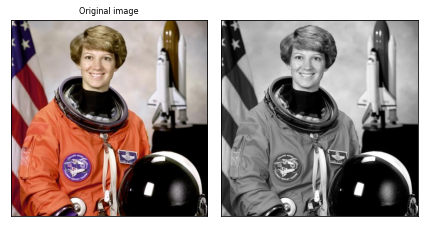

In [90]:
gray_img = T.Grayscale()(orig_img)
plot([gray_img], cmap='gray')

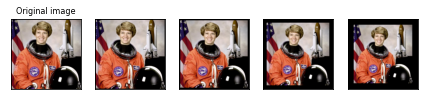

In [91]:
padded_imgs = [T.Pad(padding=padding)(orig_img) for padding in (3, 10, 30, 50)]
plot(padded_imgs)

## 自订资料集(Custom Dataset)

In [93]:
# 目标名称 --> 目标代码
labels_code = {v.lower():k for k, v in labels_map.items()}

In [95]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
import re

class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = [file_name for file_name in os.listdir(img_dir)]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 组合档案完整路径
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        # 读取图档
        image = read_image(img_path)
        # 去除副档名
        label = self.img_labels[idx].split('.')[0]
        # 将档名数字去除
        label = re.sub('[0-9]','', label)
        
        # 转换
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        # 将三维转为二维
        image = image.reshape(*image.shape[1:])
        # 反转颜色，颜色0为白色，与 RGB 色码不同，它的 0 为黑色
        image = 1.0-image
        label = labels_code[label.lower()]
        
        return image, label

In [96]:
# 模型载入
model = torch.load('./FashionMNIST.pt')

In [97]:
# 建立 transforms
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.CenterCrop(28),
    # transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float),
])

# 建立 DataLoader
test_loader = DataLoader(CustomImageDataset('./fashion_test_data', transform)
                         , shuffle=False, batch_size=10)

model.eval()
criterion = nn.CrossEntropyLoss()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        
        # 预测
        pred = output.argmax(dim=1, keepdim=True)  
        
        # 正确笔数
        correct += pred.eq(target.view_as(pred)).sum().item()

# 平均损失
test_loss /= len(test_loader.dataset)
# 显示测试结果
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(f'平均损失: {test_loss:.4f}, 准确率: {correct}/{data_count}' + 
      f' ({percentage:.0f}%)\n')

平均损失: 0.4873, 准确率: 3/7 (43%)



In [98]:
# 一次取一‘批’资料
data, target = next(iter(test_loader))
print(data.shape, target)

torch.Size([7, 28, 28]) tensor([8, 5, 5, 6, 0, 1, 1])
